# GAStimator tutorial


GAStimator is an implementation of a Python MCMC gibbs-sampler with adaptive stepping. It is simple and robust, and was developed for high dimensional problems with many degrees of freedom. It has been used extensively for kinematic modelling of molecular gas in galaxies, but is fully general and may be used for any problem MCMC methods can tackle.

### Install
You can install GAStimator with `pip install gastimator`
    
It requires the following modules:

* numpy
* matplotlib
* plotbin
* joblib

Once its installed we can get cracking!

### Basic Fitting Example

One of the most simple things you may wish to do with a minimiser is fit a gaussian to some data - so lets try that! 

First lets write a function to create the gaussian.

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def gaussian(values,x):
    mu=values[0]
    sigma=values[1]
    x = (x - mu) / sigma
    return np.exp(-x*x/2.0) / np.sqrt(2.0*np.pi) / sigma

We can then use this function to create some mock data, and add some noise:

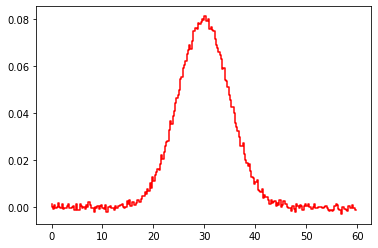

In [17]:
truth=np.array([30,5])
x=np.arange(0.,60.,0.25)
error=1e-3

data=gaussian(truth,x)
data+=np.random.normal(size=x.size)*error
plt.step(x,data,'r')

Now we have some mock data, we need to make a model function that can be used to fit it. This function MUST take a numpy array of guesses as its first argument, but can also take any number of other arguments and keywords. The function `gaussian` we defined above already fits the bill, so we are good to go.

Now we can start the fitting process. By importing GAStimator, and pointing it to the model. Any arguments can be passed as args, and any keyword arguments with kwargs. 

In [18]:
from gastimator import gastimator

mcmc = gastimator(gaussian,x)

Next we have to specify the details of the parameters we wish to use in the fit. By default GAStimator assumes flat (non-informative) priors- see later sections for how to change this.

In [19]:
mcmc.labels=np.array(['mean','stdev'])
mcmc.guesses=np.array([42,19]) # these are purposefully way off
mcmc.min=np.array([10.,0.]) # allow the fit to guess values between these minimum values
mcmc.max=np.array([50.,20.]) # ... and these maximum values
mcmc.fixed=np.array([False, False]) #if you would like to fix a variable then you can set its value to True here.

The one parameter which may need more explanation is the precision- basicly here you just want to take a guess about how well you will be able to constrain each parameter. The value you choose shouldnt be crucial for the fit, but it helps speed it up if you guess correctly...

In [20]:
mcmc.precision=np.array([1.,1.]) #here we assume we can get the intercept and gradient within ±1.0 - very conservative 

Now we are ready to go. To run the MCMC, simply pass it the data and either a vector or single value for the 1$\sigma$ errors, along with a number of samples to do, and let it get to work!

Note, if you set plot=True you can watch the chains as the progress. An example is shown below. Accepted jumps are shown in blue, while rejected jumps are in red. This is great when you are working with a new problem, but does slow things down a lot, so we will turn it off from now on in this tutorial!

<img src="files/Chain_Figure.png">

Note, by default only a single chain is used. This is often fine, but if you are worried about getting stuck in local minima you can set the `nchains` keyword to an integer. E.g. Below we use `nchains=3`. This will run multiple chains until convergence, and then run the best (that with the maximal LL) for your final output. 

In [21]:
nsamples=100000
outputvalue, outputll= mcmc.run(data,error,nsamples,nchains=3,plot=False)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


     Chain 0 has not converged - Accept rate: 0.13
     Chain 0 has not converged - Accept rate: 0.07
     --> Still varying: ['stdev']
     Chain 0 has not converged - Accept rate: 0.22
     --> Target rate not reached
Chain 0 converged: LL: -120.91831906158632 - Accept rate:0.36
     Chain 2 has not converged - Accept rate: 0.13
     Chain 2 has not converged - Accept rate: 0.06
     --> Still varying: ['mean' 'stdev']
     Chain 2 has not converged - Accept rate: 0.19
     --> Target rate not reached
Chain 2 converged: LL: -120.97123731260491 - Accept rate:0.44
     Chain 1 has not converged - Accept rate: 0.14
     Chain 1 has not converged - Accept rate: 0.07
     --> Still varying: ['mean' 'stdev']
     Chain 1 has not converged - Accept rate: 0.14
     --> Target rate not reached
Chain 1 converged: LL: -120.92926424169923 - Accept rate:0.49
Best fit:
  mean: 30.01334464083743
  stdev: 5.013796635519228
Starting final chain


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
 87%|████████▋ | 86513/99995 [00:00<00:00, 108800.73it/s][Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    2.0s remaining:    5.1s
 97%|█████████▋| 97398/99995 [00:00<00:00, 106968.34it/s][Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    2.1s remaining:    2.8s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    2.1s remaining:    1.6s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    2.1s remaining:    0.8s
100%|█████████▉| 99988/99995 [00:00<00:00, 107566.48it/s]
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    2.1s finished


Final best fit values and 1sigma errors:
  mean: 30.012081376765536 ± 0.015299899548436358
  stdev: 5.014065020189596 ± 0.01233575607773929


As you can see Gastimator prints a decent amount of information as it goes. If you dont want this, feel free to set `mcmc.silent=True`

The other thing worth noting is that by default the code will multiprocess the final chain, to get you your results faster. By default it will use all but one of the cores on your system (but warn you if the resulting chains are likely to be very short). If you want to change this behavior you need to set `mcmc.nprocesses` to the number of cores you would like to use (e.g. `mcmc.nprocesses=1` to not multiproccess).

Once the MCMC has been run, you likely want to visualise your results! I have included a version of cornor.cornor ( https://corner.readthedocs.io ), which has been modified by Michele Cappellari ( https://www-astro.physics.ox.ac.uk/~mxc/software/ ) and then further by myself. To use it to make a nice plot you just need to do:

/opt/anaconda3/lib/python3.9/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/opt/anaconda3/lib/python3.9/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


Quantiles:
[(0.16, 29.99681097464069), (0.5, 30.012081376765536), (0.84, 30.02725609172364)]
Quantiles:
[(0.16, 5.002038107668548), (0.5, 5.014065020189596), (0.84, 5.026604289800127)]


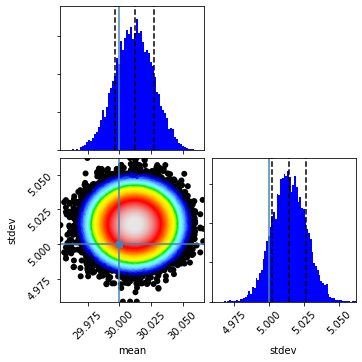

In [22]:
from gastimator import corner_plot

figure = corner_plot.corner_plot(outputvalue.T,like=outputll,labels=mcmc.labels,quantiles=[0.16, 0.5, 0.84], truths=truth)

The fit is pretty good, and the true value is within the 1$\sigma$ uncertanties! Good news!

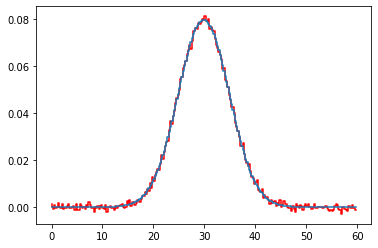

In [23]:
plt.step(x,data,'r')
plt.step(x,gaussian(np.median(outputvalue,1),x))
plt.show()

### Including priors

If you would like to include priors in your fit, GAStimator makes it easy! Currently the priors class in GAStimator includes support for gaussian priors, but its easy to add your own too.

In [24]:
from gastimator import priors

meanprior=priors.gaussian(30,1.0) # set a gaussian prior with a centre of 30, and an sigma of 1.0 for the mean
stdevprior=priors.gaussian(5.0,2) # set a gaussian prior with a centre of 4.5, and an sigma of 2 for the stdev
mcmc.prior_func=(meanprior.eval, stdevprior.eval)

If you would like to define your own prior go ahead! All you need is to create a function which takes a single number, and outputs the natural log of the probability of that guess (more advanced users can also have the prior depend on other fitting values, but this is beyond the scope of this tutorial). For instance the prior on the mean (as above) could be coded as:

In [28]:
def myown_meanprior(x,**kwargs):
    mu=30.
    sigma=1.0
    x = (x - mu) / sigma
    return (-(x*x)/2.0) - np.log(np.sqrt(2.0*np.pi)*sigma)

Which could then be included in the fit by setting:

In [29]:
mcmc.prior_func=(myown_meanprior, stdevprior.eval)

Lets give that a try!

Non uniform priors used:  mean stdev


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


     Chain 0 has not converged - Accept rate: 0.13
     Chain 0 has not converged - Accept rate: 0.09
     --> Still varying: ['stdev']
     Chain 0 has not converged - Accept rate: 0.2
     --> Target rate not reached
Chain 0 converged: LL: -123.48429104810846 - Accept rate:0.4
Best fit:
  mean: 30.007661749828074
  stdev: 5.01480135785912
Starting final chain


[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
 96%|█████████▌| 96005/99995 [00:01<00:00, 96130.21it/s][Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    2.2s remaining:    5.5s
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    2.2s remaining:    3.0s
100%|█████████▉| 99988/99995 [00:01<00:00, 94627.64it/s]
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    2.2s remaining:    1.7s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    2.3s finished


Final best fit values and 1sigma errors:
  mean: 30.011661575899076 ± 0.015524901515611589
  stdev: 5.014294446858334 ± 0.01270896614588235
Quantiles:
[(0.16, 29.99644758039798), (0.5, 30.011661575899076), (0.84, 30.02732865125382)]
Quantiles:
[(0.16, 5.00162038649958), (0.5, 5.014294446858334), (0.84, 5.0269318655353015)]


/opt/anaconda3/lib/python3.9/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/opt/anaconda3/lib/python3.9/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


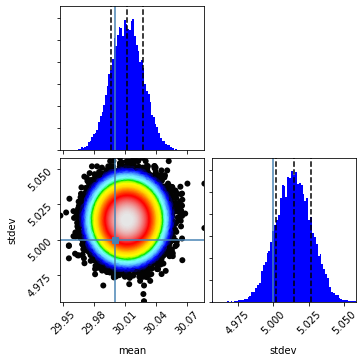

In [30]:
outputvalue, outputll= mcmc.run(data,error,nsamples,plot=False)
figure = corner_plot.corner_plot(outputvalue.T,like=outputll,labels=mcmc.labels,quantiles=[0.16, 0.5, 0.84], truths=truth)